In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [2]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [3]:
df = pd.read_sql(
    """
    SELECT 
  "gaddress", 
  replace(
    replace(price, '$', ''), 
    ',', 
    ''
  ):: numeric AS current_rent, 
  "glat"::numeric,
  "glng"::numeric,
  "bedbath", 
  "NumOfBeds", 
  "screenshot",
  "NumOfBaths", 
  coalesce(
    nullif("SqftMain", ''), 
    '0.00'
  ):: numeric(10, 2) AS sqft, 
  "BaseValue_Year", 
  "AIN",
  "CurrentRoll_BaseYear", 
  "CurrentRoll_LandValue" :: numeric + "CurrentRoll_ImpValue" :: numeric AS current_assessment 
FROM 
  "padmapper_ads" 
WHERE 
  "UseType" = 'Single Family Residence' 
  AND "SqftMain" IS NOT NULL 
  AND "NumOfBeds" != ''
  AND "NumOfBaths" != '';
""",
    con=engine,
)
df["rent_per_sqft"] = df["current_rent"] / df["sqft"]
df["assessment_per_sqft"] = df["current_assessment"] / df["sqft"]
df = df[df["assessment_per_sqft"] > 1]
df["assessment_to_rent_ratio"] = df["current_assessment"] / df["current_rent"]
df["years_held"] = df["CurrentRoll_BaseYear"].map(int) - df["BaseValue_Year"].map(int)
df = df.drop_duplicates().dropna()
df["screenshot"] = "https://rycpt-crawls.s3.us-west-2.amazonaws.com/" + df["screenshot"]
df["lagov"] = "https://portal.assessor.lacounty.gov/parceldetail/" + df["AIN"]
print(df.shape)
df

(284, 18)


gaddress  current_rent  \
0             458 Geneva Ave, Claremont, CA 91711, USA        2950.0   
1    526 Floral Park Terrace, S Pasadena, CA 91030,...        5500.0   
2     10045 W Chardonnay Ct, Sun Valley, CA 91352, USA        4800.0   
3        6627 Birchton Ave, Canoga Park, CA 91307, USA        6350.0   
4          17328 Keswick St, Northridge, CA 91325, USA        4800.0   
..                                                 ...           ...   
281          1125 Brent Ave, S Pasadena, CA 91030, USA        6500.0   
282        2019 Citrus View Ave, Duarte, CA 91010, USA        2800.0   
283    814 Monterey Blvd, Hermosa Beach, CA 90254, USA       14950.0   
284      2812 Perkins Ln, Redondo Beach, CA 90278, USA        4900.0   
285  32719 Wellbrook Dr, Westlake Village, CA 91361...        7150.0   

          glat        glng                   bedbath NumOfBeds  \
0    34.087629 -117.725562  3 Bedrooms · 2 Bathrooms         3   
1    34.119996 -118.161881   3 Bedrooms · 1 Bathroom         2   
2    34.216754 -118.350262  4 Bedrooms · 3 Bathrooms         3   
3    34.190662 -118.641677  4 Bedrooms · 2 Bathrooms         4   
4    34.209421 -118.511011  4 Bedrooms · 3 Bathrooms         3   
..         ...         ...                       ...       ...   
281  34.112907 -118.149308  5 Bedrooms · 2 Bathrooms         5   
282  34.126884 -117.987752  3 Bedrooms · 2 Bathrooms         3   
283  33.859991 -118.397255  3 Bedrooms · 3 Bathrooms         4   
284  33.881217 -118.362512  4 Bedrooms · 2 Bathrooms         4   
285  34.134179 -118.843454  5 Bedrooms · 4 Bathrooms         5   

                                            screenshot NumOfBaths    sqft  \
0    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1489.0   
1    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1575.0   
2    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          3  2392.0   
3    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1570.0   
4    https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1621.0   
..                                                 ...        ...     ...   
281  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1  2325.0   
282  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          1  1048.0   
283  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          3  1632.0   
284  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          2  1820.0   
285  https://rycpt-crawls.s3.us-west-2.amazonaws.co...          4  4258.0   

    BaseValue_Year         AIN CurrentRoll_BaseYear  current_assessment  \
0             2002  8316005016                 2022            269809.0   
1             2007  5317037006                 2022           1069336.0   
2             2002  2403029006                 2022            531483.0   
3             2010  2036026028                 2022            583847.0   
4             1981  2202009015                 2022            229484.0   
..             ...         ...                  ...                 ...   
281           1975  5318016034                 2022             77562.0   
282           1977  8531023022                 2022             35354.0   
283           2012  4187013037                 2022           1271554.0   
284           1999  4151023026                 2022            426918.0   
285           2017  2059045020                 2022           1203008.0   

     rent_per_sqft  assessment_per_sqft  assessment_to_rent_ratio  years_held  \
0         1.981195           181.201478                 91.460678          20   
1         3.492063           678.943492                194.424727          15   
2         2.006689           222.191890                110.725625          20   
3         4.044586           371.877070                 91.944409          12   
4         2.961135           141.569402                 47.809167          41   
..             ...                  ...                       ...         ..

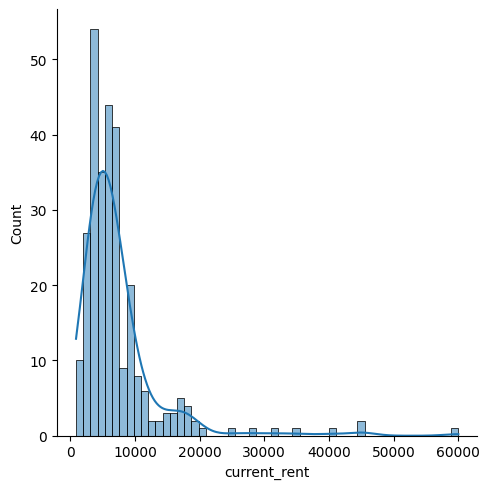

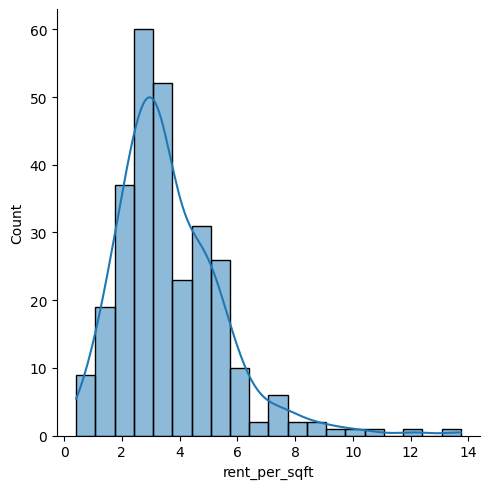

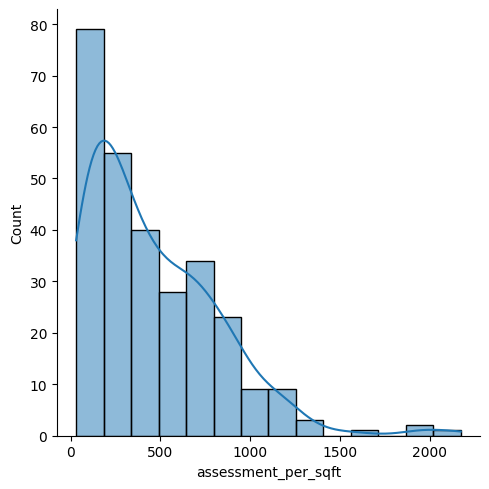

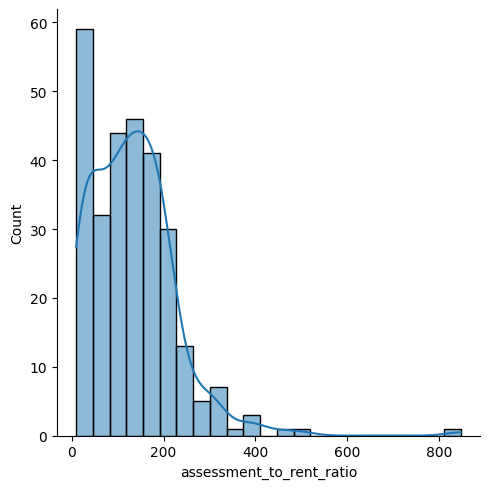

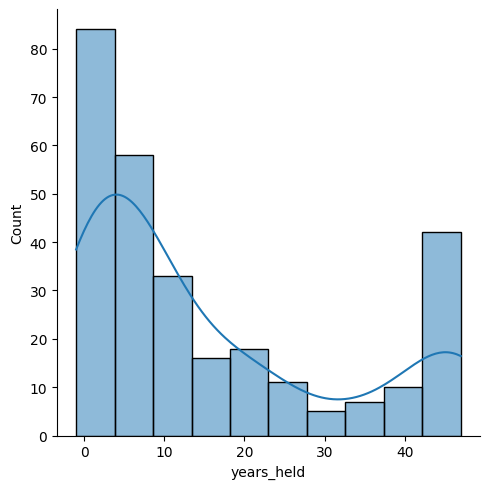

In [4]:
# loop through each column and plot a displot
for column in [
    "current_rent",
    "rent_per_sqft",
    "assessment_per_sqft",
    "assessment_to_rent_ratio",
    "years_held",
]:
    sns.displot(df[column], kde=True)

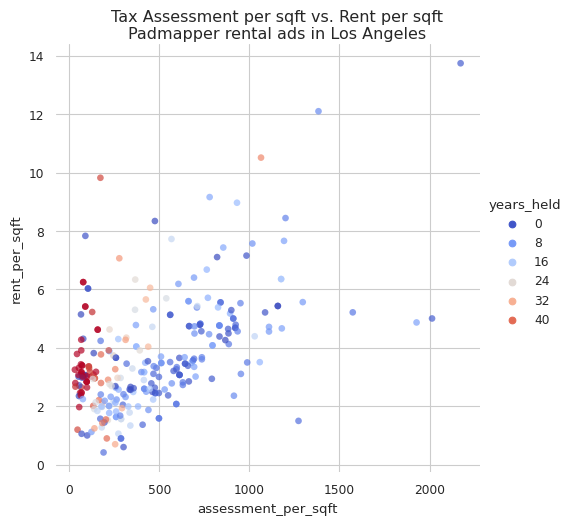

In [9]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)
# cmap = sns.color_palette("dark:salmon_r", as_cmap=True)
# cmap = sns.color_palette()

g = sns.relplot(
    data=df,
    x="assessment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.7,
    palette=cmap,
)
g.despine(left=True, bottom=True)
plt.suptitle(
    "Tax Assessment per sqft vs. Rent per sqft\nPadmapper rental ads in Los Angeles",
    y=1.04,
)
plt.savefig(
    os.path.join(
        os.environ["HOME"], "ryancompton.net/assets/pix/tax_vs_rent_padmapper.png"
    )
)

In [6]:
hex_cmap = sns.color_palette("coolwarm", n_colors=len(set(df.years_held))).as_hex()


def get_color(x):
    for idx, years in enumerate(sorted(set(df.years_held))):
        if x == years:
            return hex_cmap[max(0, idx)]


df["gmap_color"] = df["years_held"].map(get_color)

df["assessment_to_rent_ratio"] = df["assessment_to_rent_ratio"].round(2)
dfp = df[
    [
        "glat",
        "glng",
        "gmap_color",
        "gaddress",
        "current_rent",
        "current_assessment",
        "assessment_to_rent_ratio",
        "BaseValue_Year",
        "lagov",
        "screenshot",
    ]
]
print(dfp.sample(10).to_csv(sep="\t", index=False))

glat	glng	gmap_color	gaddress	current_rent	current_assessment	assessment_to_rent_ratio	BaseValue_Year	lagov	screenshot
34.041647	-118.4985774	#4f69d9	253 18th St, Santa Monica, CA 90402, USA	40000.0	6324000.0	158.1	2021	https://portal.assessor.lacounty.gov/parceldetail/4279011020	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-21/253_18th_St,_Santa_Monica,_CA_90402,_USA.png
34.1702724	-118.364035	#a2c1ff	5509 Cartwright Ave a, North Hollywood, CA 91601, USA	7500.0	425714.0	56.76	2010	https://portal.assessor.lacounty.gov/parceldetail/2416018019	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-19/5509_Cartwright_Ave_a,_North_Hollywood,_CA_91601,_USA.png
34.0106361	-118.4724768	#4055c8	1311 Maple St, Santa Monica, CA 90405, USA	9000.0	512663.0	56.96	2023	https://portal.assessor.lacounty.gov/parceldetail/4284027011	https://rycpt-crawls.s3.us-west-2.amazonaws.com/padmapper-data/2023-04-10/1311_Maple_St,_Santa_Monica,_CA_90405,_USA.png
33.7988948	

In [7]:
dfp.to_csv(
    "/home/ryn/ryancompton.net/assets/taxrentlocations.tsv", sep="\t", index=False
)